In [2]:
import os
import cv2
import sys
import math
import time
import numpy as np #uncommented
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

#from torch import np #commented
from torch.autograd import Variable

from utils import *
from pose_estimation_fin import *


[[[ 23  37  43]
  [ 20  34  40]
  [ 19  30  34]
  ...
  [ 16  26  20]
  [ 15  25  19]
  [ 15  25  19]]

 [[ 23  37  43]
  [ 20  34  40]
  [ 19  30  34]
  ...
  [ 15  25  19]
  [ 15  25  19]
  [ 15  25  19]]

 [[ 23  37  43]
  [ 20  34  40]
  [ 19  30  34]
  ...
  [ 14  24  18]
  [ 14  24  18]
  [ 14  24  18]]

 ...

 [[ 82 146 124]
  [ 82 146 124]
  [ 82 146 124]
  ...
  [ 66 130 100]
  [ 65 129  99]
  [ 65 129  99]]

 [[ 80 145 123]
  [ 81 146 124]
  [ 81 146 124]
  ...
  [ 66 130 100]
  [ 66 130 100]
  [ 65 129  99]]

 [[ 79 144 122]
  [ 80 145 123]
  [ 80 145 123]
  ...
  [ 67 131 101]
  [ 66 130 100]
  [ 66 130 100]]]
(784, 1200, 3)


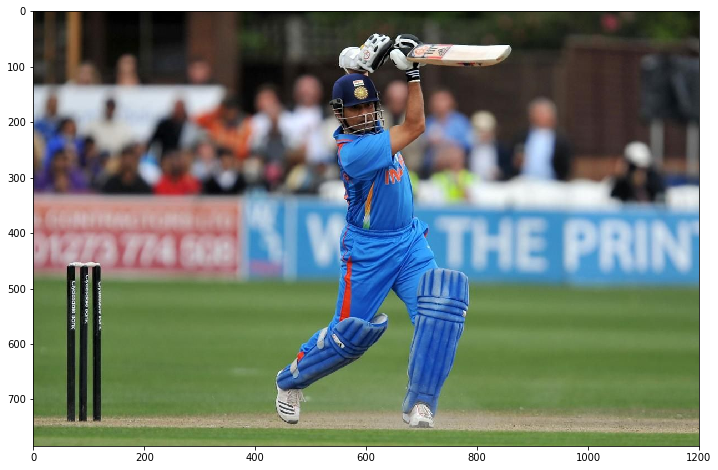

In [3]:
#use_gpu = True #commented

test_image = './test1.jpg'
img_ori = cv2.imread(test_image) # B,G,R order

# display the validation pics
print(img_ori)
print(img_ori[...,::-1].shape)
plt.figure(figsize=(12, 8))
plt.imshow(img_ori[...,::-1]) #reversing image to display in color in matplolib

In [ ]:
#example of reversing technique above
#d = np.array([[[i + 2*j + 8*k for i in range(3)] for j in range(3)] for k in range(3)])
#print(d[...,::-1])

In [5]:
#loads the file. File is in dictionary structure
model_data = torch.load('./models/coco_pose_iter_440000.pth.tar') 
type(model_data) 

dict

In [6]:
#the key 'state_dict' in the loaded dictionary contains weights and bias of all the layers in the model.
state_dict = model_data['state_dict']
state_dict

OrderedDict([('model0.0.weight',
              tensor([[[[ 4.7961e-01,  5.2599e-01,  7.6868e-04],
                        [ 2.8139e-01,  2.0236e-01, -4.2591e-01],
                        [-1.3844e-01, -4.5789e-01, -3.9033e-01]],
              
                       [[ 7.8953e-01,  8.6122e-01, -5.0837e-02],
                        [ 4.7011e-01,  2.7503e-01, -7.4499e-01],
                        [-2.1292e-01, -6.8554e-01, -7.5140e-01]],
              
                       [[ 7.1588e-01,  7.4054e-01, -5.9342e-02],
                        [ 4.2527e-01,  2.2352e-01, -7.0010e-01],
                        [-1.3017e-01, -5.7792e-01, -6.0052e-01]]],
              
              
                      [[[ 1.2350e-01,  1.9557e-01,  9.3258e-02],
                        [ 1.6689e-01,  2.5475e-01,  9.3090e-02],
                        [ 1.2223e-01,  1.8654e-01,  8.1906e-02]],
              
                       [[ 7.9575e-02,  1.1921e-01,  3.9197e-02],
                        [ 1.1189e-01,  1.7

In [7]:
#state_dict has the weights and biases for all the layers (state_dict has 184 elements (which are weights and biases one after other))
#here, lists the shapes of weights and biases of the whole model
for i in state_dict:
    print(state_dict[i].shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([256, 512, 3, 3])
torch.Size([256])
torch.Size([128, 256, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([512, 128, 1, 1])
torch.Size([512])
torch.Size([38, 512, 1, 1])
torch.Size([38])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([512, 128, 1, 1])
torch.Size([512])
torch.Size([19, 512, 1,

In [8]:
#printing model weights and biases of the first few conv layers
print("Conv 1")
print(state_dict['model0.0.weight'])
print(state_dict['model0.0.weight'].shape)

print("Conv 2")
print(state_dict['model0.2.weight'])
print(state_dict['model0.2.weight'].shape)

print("Conv 3")
print(state_dict['model0.5.weight'])
print(state_dict['model0.5.weight'].shape)

Conv 1
tensor([[[[ 4.7961e-01,  5.2599e-01,  7.6868e-04],
          [ 2.8139e-01,  2.0236e-01, -4.2591e-01],
          [-1.3844e-01, -4.5789e-01, -3.9033e-01]],

         [[ 7.8953e-01,  8.6122e-01, -5.0837e-02],
          [ 4.7011e-01,  2.7503e-01, -7.4499e-01],
          [-2.1292e-01, -6.8554e-01, -7.5140e-01]],

         [[ 7.1588e-01,  7.4054e-01, -5.9342e-02],
          [ 4.2527e-01,  2.2352e-01, -7.0010e-01],
          [-1.3017e-01, -5.7792e-01, -6.0052e-01]]],


        [[[ 1.2350e-01,  1.9557e-01,  9.3258e-02],
          [ 1.6689e-01,  2.5475e-01,  9.3090e-02],
          [ 1.2223e-01,  1.8654e-01,  8.1906e-02]],

         [[ 7.9575e-02,  1.1921e-01,  3.9197e-02],
          [ 1.1189e-01,  1.7465e-01,  2.1139e-02],
          [ 1.0343e-01,  1.3978e-01,  4.5137e-02]],

         [[-1.6450e-01, -1.8467e-01, -1.9948e-01],
          [-1.8189e-01, -1.8254e-01, -2.7686e-01],
          [-1.2067e-01, -1.4906e-01, -1.9753e-01]]],


        [[[-1.6805e-01,  3.4063e-02, -2.4961e-01],
        

          [ 5.6718e-02,  6.4338e-02,  1.3904e-02]]]])
torch.Size([64, 64, 3, 3])
Conv 3
tensor([[[[ 3.2721e-02, -1.1105e-02, -1.4414e-02],
          [ 4.7907e-03, -5.3869e-02, -4.2999e-02],
          [ 2.5433e-02, -2.0095e-02,  1.1487e-02]],

         [[ 2.6111e-02,  3.5956e-02,  3.8632e-02],
          [ 9.6483e-03, -1.8253e-02, -5.1111e-03],
          [-9.2261e-03, -3.1899e-02,  1.2049e-02]],

         [[-4.2485e-03, -8.8994e-03,  7.8853e-03],
          [ 3.0606e-03, -1.0010e-02, -9.8194e-05],
          [ 1.4462e-02,  9.4760e-03,  2.0390e-02]],

         ...,

         [[-9.2274e-03, -2.4300e-02, -8.4451e-03],
          [-2.5216e-02, -4.7932e-02, -2.5719e-02],
          [-2.9366e-02, -5.0040e-02, -2.1848e-02]],

         [[-1.4121e-03, -2.4559e-02, -1.4548e-02],
          [-4.0604e-02, -4.7284e-02, -1.8816e-02],
          [-3.3283e-03, -1.2760e-02,  1.2295e-02]],

         [[-9.2900e-03, -1.2741e-02, -9.4207e-03],
          [-1.9290e-02, -2.0653e-02, -1.2164e-03],
          [-8.4392e-

In [9]:
#calling the class get_pose_model()to initialize the model structure
model_pose = get_pose_model()
#loading the weights and biases of the pre trained model into the initialized model
model_pose.load_state_dict(state_dict) 
model_pose.float()
model_pose.eval()

PoseEstimation(
  (model0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1,

In [ ]:
#No. of input and output channels at each stage based on the above model

#model0 - (VGG-19) 
#input - 3, output - 128

#model1_1 (upper branch - stage1)
#input - 128, output - 38(confidence maps)

#model1_2 (lower branch - stage1)
#input - 128, output - 19(PAFs)

#model2_1 (upper branch - stage2)
#input - 185(38 confidence maps from model1_1 + 19 PAFs from model1_2 + 128(image features)), output - 38(confidence maps)

#model2_2 (lower branch - stage2)
#input - 185(38 confidence maps from model1_1 + 19 PAFs from model1_2 + 128(image features)), output - 19(PAFs)

#model3_1 (upper branch - stage3)
#input - 185(38 confidence maps from model2_1 + 19 PAFs from model2_2 + 128(image features)), output - 38(confidence maps)

#model3_2 (lower branch - stage3)
#input - 185(38 confidence maps from model2_1 + 19 PAFs from model2_2 + 128(image features)), output - 19(PAFs)

#model4_1 (upper branch - stage4)
#input - 185(38 confidence maps from model3_1 + 19 PAFs from model3_2 + 128(image features)), output - 38(confidence maps)

#model4_2 (lower branch - stage4)
#input - 185(38 confidence maps from model3_1 + 19 PAFs from model3_2 + 128(image features)), output - 19(PAFs)

#model5_1 (upper branch - stage5)
#input - 185(38 confidence maps from model4_1 + 19 PAFs from model4_2 + 128(image features)), output - 38(confidence maps)

#model5_2 (lower branch - stage5)
#input - 185(38 confidence maps from model4_1 + 19 PAFs from model4_2 + 128(image features)), output - 19(PAFs)

#model6_1 (upper branch - stage6)
#input - 185(38 confidence maps from model5_1 + 19 PAFs from model5_2 + 128(image features)), output - 38(confidence maps)

#model6_2 (lower branch - stage6)
#input - 185(38 confidence maps from model5_1 + 19 PAFs from model5_2 + 128(image features)), output - 19(PAFs)

In [ ]:
#if use_gpu:
#    model_pose.cuda()
#    model_pose = torch.nn.DataParallel(model_pose, device_ids=range(torch.cuda.device_count()))
#    cudnn.benchmark = True

In [ ]:
#%%time - a magical command used to print the cpu and wall clock times to execute a cell. 
#if in line mode, use %time

In [10]:
#%%time - if this is executed, the variable used in the cells could not be used in other cells. So, commented.
scale_param = [0.5, 1.0, 1.5, 2.0]
scale_param1=[0.5,1.0] #only one scale to reduce complexity
paf_info, heatmap_info = get_paf_and_heatmap(model_pose, img_ori, scale_param1) #passing scale param1 - only one scale

torch.Size([1, 38, 23, 36])
torch.Size([1, 19, 23, 36])
torch.Size([1, 38, 46, 71])
torch.Size([1, 19, 46, 71])


In [ ]:
#a simple representation of the get_paf_and_heatmap function in pose_estimation.py
from utils import *
box=368 #image size to pass to the model
scale_param1=[0.5] #only  one scale is mentioned to reduce computation
mult=[scale * box/img_ori.shape[0] for scale in scale_param1] #size of a single pixel after reducing to size 368 with a scale factor 0.5
heatmap_avg=torch.zeros(2,19,img_ori.shape[0],img_ori.shape[1]) #empty structure of shape (2, 19, 938, 1395) to store the 19 heatmaps
                                                                #2 refers two scales. Though we have only one scale, the same data is stored 
                                                                #twice with lil changes to reduce computation.
paf_avg=torch.zeros(2,38,img_ori.shape[0],img_ori.shape[1]) #same as above but to store pafs

for i,scale in enumerate(mult):
    print(scale)
    img_t=cv2.resize(img_ori,(0,0),fx=scale,fy=scale, interpolation=cv2.INTER_CUBIC) #resizing image to 38 with a scale 0.5
    img_t_pad,pad=pad_right_down_corner(img_t,8,8) #padding to accomadate a stride of 8
    img_t_pad=np.transpose(np.float32(img_t_pad[:,:,:,np.newaxis]),(3,2,0,1))/256-0.5 #adding a new axis(dim 1) and transposing to form a single list and normalizing.
    feed=Variable(torch.from_numpy(img_t_pad)) #numoy to tensor form
    out1,out2=model_pose(feed) #passing the resized image (tensor) to the model
    
    print("Image size after padding: ",img_t_pad.shape) #shape after padding
    print("Image size of pafs: ",out1.shape) #size of the paf
    print("Image size of heatmaps: ",out2.shape) #size of the heatmap 
    print("\n")
    
    heatmap=nn.UpsamplingBilinear2d((img_ori.shape[0],img_ori.shape[1]))(out2) #upsampling back to the size 19, 928, 1395
    paf=nn.UpsamplingBilinear2d((img_ori.shape[0],img_ori.shape[1]))(out1) #upsampling back to the size 38, 928, 1395
    print("Image size of upsampled heatmaps: ",heatmap.shape) #shape of upsampled heatmap
    print("Image size of upsampled pafs: ",paf.shape) #shape of upsampled paf
    print("\n") 
    
    heatmap_avg[0],heatmap_avg[1]=heatmap[0].data,heatmap[0].data+.0001 #here, two heatmaps are considered (one is obtained by changing values to the other to reduce computation in this example)
    print("After torch.mean(heatmaps): ",torch.mean(heatmap_avg,0).shape) #find the mean of the heatmaps generated(each from different scales)
    print("After torch.squeeze(heatmaps): ",torch.squeeze(torch.mean(heatmap_avg,0)).shape) #squeeze the tensor (if size is 25*1*30) it becomes 25*30
    print("After first torch.transpose(heatmaps): ",torch.transpose(torch.squeeze(torch.mean(heatmap_avg,0)),0,1).shape) #transpose by interchanging 0th and 1st dimensions
    heatmap_avg=torch.transpose(torch.transpose(torch.squeeze(torch.mean(heatmap_avg,0)),0,1),1,2) #transpose again by interchanging 1st and 2nd dimensions
    heatmap_avg=heatmap_avg.numpy() #converts back to numpy
    print("\n")
    
    #same as above, but for pafs
    paf_avg[0],paf_avg[1]=paf[0].data,paf[0].data+.0001
    print("After torch.mean (pafs): ",torch.mean(paf_avg,0).shape)
    print("After torch.squeeze (pafs): ",torch.squeeze(torch.mean(paf_avg,0)).shape)
    print("After first torch.transpose (pafs): ",torch.transpose(torch.squeeze(torch.mean(paf_avg,0)),0,1).shape)
    paf_avg=torch.transpose(torch.transpose(torch.squeeze(torch.mean(paf_avg,0)),0,1),1,2)
    paf_avg=paf_avg.numpy()
    print("\n")

print("Final heatmaps: ",heatmap_avg)
print("Final pafs: ",paf_avg)
print("Final heatmaps size: ",heatmap_avg.shape)
print("Final pafs size: ",paf_avg.shape)


Final pafs size:  (784, 1200, 38)
PAFs [[[ 3.86824831e-04  5.68563526e-04 -8.51588120e-05 ...  7.96671375e-05
    1.04396750e-04  7.19609234e-05]
  [ 3.88333690e-04  5.74633828e-04 -8.49641801e-05 ...  7.97060347e-05
    1.04547216e-04  7.19735472e-05]
  [ 3.89842608e-04  5.80704131e-04 -8.47695337e-05 ...  7.97449320e-05
    1.04697698e-04  7.19861855e-05]
  ...
  [ 4.40543838e-04  7.84679607e-04 -7.82293500e-05 ...  8.10519705e-05
    1.09753841e-04  7.24105776e-05]
  [ 4.43787576e-04  7.97729415e-04 -7.78109243e-05 ...  8.11355858e-05
    1.10077322e-04  7.24377242e-05]
  [ 4.47031314e-04  8.10779165e-04 -7.73924985e-05 ...  8.12192084e-05
    1.10400797e-04  7.24648708e-05]]

 [[ 3.85276566e-04  5.62334666e-04 -8.53585370e-05 ...  7.96272216e-05
    1.04242354e-04  7.19479576e-05]
  [ 3.86418134e-04  5.66927425e-04 -8.52112862e-05 ...  7.96566455e-05
    1.04356193e-04  7.19575182e-05]
  [ 3.87559761e-04  5.71520126e-04 -8.50640135e-05 ...  7.96860841e-05
    1.04470040e-04  7.1967

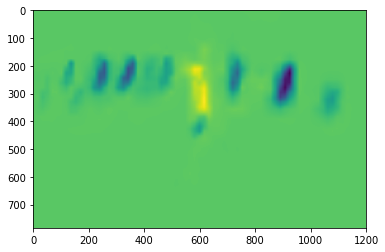

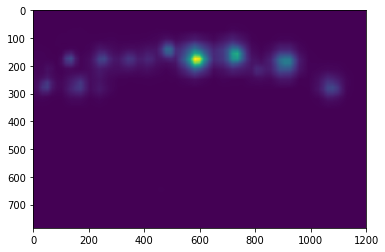

In [11]:
#a representation of the heatmaps and pafs generated (only the last heatmap and last paf is shown)
plot1=plt.figure(1)
print("Final pafs size: ",paf_info.shape)
print("PAFs",paf_info)
print("Final heatmaps size: ",heatmap_info.shape)
print("Heatmaps",heatmap_info)
plt.imshow(paf_info[:,:,0])
plot2=plt.figure(2)
plt.imshow(heatmap_info[:,:,0])

### Heat Map

In [12]:
#%%time
peaks = extract_heatmap_info(heatmap_info)
print(peaks)
print("\nNo. of peaks(Keypoints)",len(peaks))
#two pixel details (peaks) for each keypoint beacuse there are two persons in the image passed.

[[(486, 141, 0.2567321, 0), (733, 159, 0.4784116, 1), (135, 175, 0.1716342, 2), (253, 176, 0.15847155, 3), (345, 176, 0.1172696, 4), (586, 176, 0.79078245, 5), (911, 183, 0.32807803, 6), (49, 274, 0.13231964, 7), (170, 274, 0.12871535, 8), (169, 275, 0.12744537, 9), (1076, 280, 0.1666004, 10)], [(481, 177, 0.4402567, 11), (347, 193, 0.40988037, 12), (414, 193, 0.18885237, 13), (735, 193, 0.71958596, 14), (253, 194, 0.4138863, 15), (135, 206, 0.3066587, 16), (911, 225, 0.6879153, 17), (587, 226, 0.69728565, 18), (807, 242, 0.113348864, 19), (38, 296, 0.13183424, 20), (156, 298, 0.17996302, 21), (1081, 299, 0.30240548, 22)], [(462, 188, 0.42393416, 23), (322, 192, 0.33958125, 24), (227, 194, 0.38039026, 25), (703, 195, 0.63856345, 26), (105, 206, 0.24527827, 27), (890, 223, 0.7129636, 28), (564, 242, 0.69289315, 29), (812, 242, 0.107547924, 30), (25, 297, 0.121721365, 31), (137, 300, 0.20890386, 32), (1060, 300, 0.33966118, 33)], [(683, 193, 0.54978305, 34), (206, 227, 0.32734033, 35), (

In [34]:
#a simple representation of the extract_heatmap_info function in pose_estimation.py using only the last heatmap (18th) to reduce computation
peak_counter=0
all_peaks=[]
map_ori=heatmap_info[:,:,16] #heatmap of 18th keypoint
print("heatmap 18: \n",map_ori)
#guassian filtering - filtering (blurring) method through kernel convolution where the kernel is a gaussian kernel which has values that 
#follow normal ditribution. Therefore, the weight at the center of the kernel is greater than the others (like a bell curve).
#This helps the edges to be sharp and the background to be blurry, so that edge detection can be done easily.
map_gau=gaussian_filter(map_ori,sigma=3) 
print("\n")
print("Gaussian filter: \n",map_gau) #heatmap after gaussian filter (edges are sharp now)
print("\n")
#Next, location of edges are detected by identifying which of the pixels are greater than all its neighbouring pixels (indicating
#an edge). To do this, 4 copies of the heatmap obtained is made, and in each the pixels are moved a row to the left, right, up and
#down to make comparisons
map_left=np.zeros(map_gau.shape)
map_right=np.zeros(map_gau.shape)
map_up=np.zeros(map_gau.shape)
map_down=np.zeros(map_gau.shape)
map_left[1:,:]=map_gau[:-1,:]
map_right[:-1,:]=map_gau[1:,:]
map_up[:,1:]=map_gau[:,:-1]
map_down[:,:-1]=map_gau[:,1:]
print(map_left)
print("\n")
print(map_right)
print("\n")
print(map_up)
print("\n")
print(map_down)
print("\n")
param_thre1=0.1
#np.logical_and.reduce returns true for each pixel if all the 5 conditions mentioned as the arguments are followed by each of them
#it returns a binary matrix of the same shape as the input heatmap(guassian filtered)
peaks_binary = np.logical_and.reduce(
            (map_gau >= map_left, map_gau >= map_right, map_gau >= map_up, map_gau >= map_down, map_gau>param_thre1))

print("Shape of the guassian filtered heatmap: ",map_gau.shape)
print("Shape of the peaks_binary: ",peaks_binary.shape)
print("Total elements in peaks_binary: ",peaks_binary.shape[0]*peaks_binary.shape[1])
print("No. of Falses: ",np.count_nonzero(peaks_binary==0)) #pixels which doesn't form the edges
print("No. of Trues: ",np.count_nonzero(peaks_binary==1)) #pixels which forms the edges
print("\n")
#np.nonzero returns the indices of the nonzero elements. Here, the indices of true values. If 2 dimensional, the x and y coordinates
#of the true values are returned in two different arrays. So, they are zipped together to form a tuple
peaks=list(zip(np.nonzero(peaks_binary)[1],np.nonzero(peaks_binary)[0])) #list of tuples
peaks_with_score=[i+(map_ori[i[1],i[0]],) for i in peaks] #the indices are concatenated with the pixel value (score) in the index location
print("The indices of the peaks or keypoint (edges) with its pixel value: \n")
print(peaks_with_score[:10]) #first 10 pixels of edges details
ids=range(peak_counter, peak_counter+len(peaks)) 
peaks_with_score_and_id=[peaks_with_score[i]+(ids[i],) for i in range(len(ids))] #concatenating a unique id to each of the identified pixels details
print("\nA unique id added to the above: \n")
print(peaks_with_score_and_id[:10])
all_peaks.append(peaks_with_score_and_id) #appending the peaks or edges identified for each heatmap. This example, only one heatmap is used (18th)
peak_counter+=len(peaks)
print(len(all_peaks[0]))
print(peak_counter)

heatmap 18: 
 [[7.52902997e-05 7.47949525e-05 7.42996053e-05 ... 1.05156949e-04
  1.06403109e-04 1.07649277e-04]
 [7.47885788e-05 7.43089913e-05 7.38294038e-05 ... 1.07170199e-04
  1.08546294e-04 1.09922374e-04]
 [7.42868651e-05 7.38230301e-05 7.33591878e-05 ... 1.09183449e-04
  1.10689456e-04 1.12195470e-04]
 ...
 [1.54417939e-04 1.51702538e-04 1.48987136e-04 ... 8.22979637e-05
  8.33590530e-05 8.44201350e-05]
 [1.52219931e-04 1.49590836e-04 1.46961713e-04 ... 8.30913996e-05
  8.41812289e-05 8.52710509e-05]
 [1.50022111e-04 1.47479295e-04 1.44936435e-04 ... 8.38847700e-05
  8.50033393e-05 8.61219014e-05]]


Gaussian filter: 
 [[7.34175846e-05 7.32972985e-05 7.30690444e-05 ... 1.08028158e-04
  1.08763699e-04 1.09151311e-04]
 [7.32956541e-05 7.31764158e-05 7.29501626e-05 ... 1.08526045e-04
  1.09278095e-04 1.09674409e-04]
 [7.30642641e-05 7.29470339e-05 7.27245788e-05 ... 1.09470828e-04
  1.10254208e-04 1.10667032e-04]
 ...
 [1.50552674e-04 1.49834625e-04 1.48472071e-04 ... 8.10368219e-

In [ ]:
connection_candidate1=sorted(connection_candidate, reverse=True, key=lambda x:x[2])
print(connection_candidate1)
connection=np.zeros((0,5))
print(connection)
for c in range(len(connection_candidate1)):
    i,j,s=connection_candidate1[c][0:3]
    if i not in connection[:, 3] and j not in connection[:, 4]:
        print("Hello",connection[:, [3,4]])
        connection=np.vstack([connection, [candA[i][3], candB[i][3],s,i,j]])
        if(len(connection)>=min(nA,nB)):
            break
    print(connection)

In [ ]:
connection_candidate1=sorted(connection_candidate, reverse=True, key=lambda x:x[2])
print(connection_candidate1)
connection=np.zeros((0,5))
print(connection)
for c in range(len(connection_candidate1)):
    i,j,s=connection_candidate1[c][0:3]
    print("Hello",connection[:, [3,4]])
    connection=np.vstack([connection, [candA[i][3], candB[i][3],s,i,j]])
    print(connection)

In [ ]:
peaks1

In [13]:
#%%time
sp_k, con_all = extract_paf_info(img_ori, paf_info, peaks)
#sp_k - heatmaps indices which identifies no peaks
#con_all - the final set of connections

In [14]:
print(sp_k)
print("\n Final connections")
print(con_all)
print(len(con_all))

[]

 Final connections
[array([[14.        , 26.        ,  0.7879091 ,  3.        ,  3.        ],
       [17.        , 28.        ,  0.75706139,  6.        ,  5.        ],
       [18.        , 29.        ,  0.72945732,  7.        ,  6.        ],
       [12.        , 24.        ,  0.47353659,  1.        ,  1.        ],
       [15.        , 25.        ,  0.43130019,  4.        ,  2.        ],
       [11.        , 23.        ,  0.36070344,  0.        ,  0.        ],
       [16.        , 27.        ,  0.32078551,  5.        ,  4.        ],
       [22.        , 33.        ,  0.30650958, 11.        , 10.        ],
       [21.        , 32.        ,  0.179829  , 10.        ,  9.        ],
       [20.        , 31.        ,  0.1744568 ,  9.        ,  8.        ]]), array([[14.        , 44.        ,  0.84415088,  3.        ,  1.        ],
       [17.        , 49.        ,  0.78055921,  6.        ,  6.        ],
       [18.        , 48.        ,  0.70720637,  7.        ,  5.        ],
       [12. 

In [ ]:
#a simple representation of the extract_paf_info function in pose_estimation.py using only the first two sets of midjoints to reduce computation
#these are the limbs formed by two keypoints. Keypoints are indexed from 1 to 18
limb_seq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10],
            [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17],
            [1, 16], [16, 18], [3, 17], [6, 18]]

# the middle joints heatmap correpondence. These are the middle joints that comes between two keypoints(a limb). They are
#mentioned in the same oder as limb_seq.
map_ids = [[31, 32], [39, 40], [33, 34], [35, 36], [41, 42], [43, 44], [19, 20], [21, 22],
           [23, 24], [25, 26], [27, 28], [29, 30], [47, 48], [49, 50], [53, 54], [51, 52],
           [55, 56], [37, 38], [45, 46]]

# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0],
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255],
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
mid_num=50 #No. of points to be identified in a limb. (Between 2 keypoints)
param_thre2=0.05 #Threshold value of PAFs. 
connection_candidate=[] #To store the connections identified whose PAF values meets certain criteria(above a threshold value)
connection_all=[]  #stores the curated set of connections - Connections which had Maximum PAF value between two keypoints
special_k=[] #stores the index of the heatmaps which didn't identify any peaks
for k in range(2):
    score_mid=paf_avg[:,:,[x-19 for x in map_ids[k]]] #stores only the values in the paf maps at the two indices mentioned in each of the elements in map_ids list that represents joints b/w keypoints
    candA=peaks1[limb_seq[k][0]-1] #stores the peaks(its  index, score and id) of the first keypoint mentioned in each of the elements in limb_seq list
    candB=peaks1[limb_seq[k][1]-1] #stores the peaks(its  index, score and id)  of the second keypoint mentioned in each of the elements in limb_seq list
    nA=len(candA) #length of the peaks of first keypoint - if two persons are there in the image, then length is two since there are two peaks
    nB=len(candB) #length of the peaks of second keypoint
    if nA!=0 and nB!=0: #checks if peaks are ientified for both keypoints
        for i in range(nA):
            for j in range(nB):
                vec=np.subtract(candB[j][:2],candA[i][:2]) #finds direction vector from peak B to peak A by subtracting the index locations
                print(vec) #direction vector
                norm=math.sqrt(vec[0]*vec[0] + vec[1]*vec[1]) #the magnitude of the direction vector
                print(norm)
                vec=np.divide(vec,norm) #obtains unit vector - direction vector/its magnitude
                print(vec)
                startend=zip(np.linspace(candA[i][0], candB[j][0], num=mid_num),
                             np.linspace(candA[i][1], candB[j][1], num=mid_num)) #finds 50(mid_num) index locations between the two peaks or keypoints
                startend=list(startend)
                print(startend)
                print(len(startend)) 
                vec_x=np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0]
                                for I in range(len(startend))]) #finds the score x (pixel value) of the joints at the 50 index location
                vec_y=np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1]
                                for I in range(len(startend))]) #finds the score y (pixel value) of the joints at the 50 index location
                print(vec_x)
                print(vec_y)
                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1]) #paf values for every 50 index locations (new magnitudes of the direction vector by multiplying x and y scores with the unit vector)
                print(score_midpts)
                score_with_dist_prior = sum(score_midpts) / len(score_midpts) #average paf value
                score_with_dist_prior+=min(0.5 * img_ori.shape[0] / norm - 1, 0) #value added to paf to penalize long limb connections. if long limb norm(magnitude of direction vector) will be higher. So,minimun would be the division term and not zero
                print(score_with_dist_prior)
                criterion1 = len(np.nonzero(score_midpts > param_thre2)[0]) > 0.8 * len(score_midpts) #returns true if there are above 80% of paf values that is greater than the threshold value(0.05) 
                criterion2 = score_with_dist_prior > 0 #whether average paf value is greater than 0
                if criterion1 and criterion2: #if both criteria are followed, the indices of the persons with the keypoint in the image(0 - first person, 1 - second person and so on), the paf value of the connection is stored
                    connection_candidate.append(
                        [i, j, score_with_dist_prior, score_with_dist_prior + candA[i][2] + candB[j][2]])
        connection_candidate1=sorted(connection_candidate, reverse=True, key=lambda x:x[2]) #sorts the connections in descending order based on the paf value of the connection
        print(connection_candidate1)
        connection=np.zeros((0,5)) #empty numpy array to store 5 values associated with each connections
        print(connection)
        for c in range(len(connection_candidate1)):
            i,j,s=connection_candidate1[c][0:3] #stores indices of the persons with the keypoints and the paf value of the connection between them
            if i not in connection[:, 3] and j not in connection[:, 4]: #condition is true if the connection between keypoints of two particular persons are not present. So, such a connection with highest paf value will be stored and other possible connections are ignored
                print("Hello",connection[:, [3,4]])
                connection=np.vstack([connection, [candA[i][3], candB[i][3],s,i,j]]) #stores the unique id of the keypoints, connection PAF value, and the indices of the persons with the keypoints
                if(len(connection)>=min(nA,nB)): #length of the connections between two keypoints of multiple persons should be equal to the number of persons
                    break
        connection_all.append(connection) #appends connnections between all the keypoints mentioned in map_ids list
    else:
        special_k.append(k) #index of the heatmaps which didn't identify any peaks
        connection_all.append([])
print("\n\n\n")
print(connection_candidate)
print(special_k)
print(connection_all)

In [15]:
#%%time
subsets, candidates = get_subsets(con_all, sp_k, peaks)

In [16]:
subsets

array([[  1.        ,  14.        ,  26.        ,  -1.        ,
         -1.        ,  44.        ,  55.        ,  60.        ,
         66.        ,  -1.        ,  -1.        ,  74.        ,
         -1.        ,  -1.        ,  81.        ,  90.        ,
        100.        , 105.        ,  12.14426049,  12.        ],
       [  6.        ,  17.        ,  28.        ,  38.        ,
         -1.        ,  49.        ,  57.        ,  61.        ,
         67.        ,  -1.        ,  -1.        ,  75.        ,
         -1.        ,  -1.        ,  85.        ,  95.        ,
        102.        , 108.        ,  10.41490202,  13.        ],
       [  5.        ,  18.        ,  29.        ,  37.        ,
         -1.        ,  48.        ,  53.        ,  58.        ,
         68.        ,  69.        ,  70.        ,  76.        ,
         78.        ,  79.        ,  82.        ,  91.        ,
        101.        ,  -1.        ,  20.02824724,  16.        ],
       [  4.        ,  12.        ,  

In [131]:
a=np.array([[1,2,3,5],[2,3,4,5]])
print(a)
np.delete(a,0,axis=0)

[[1 2 3 5]
 [2 3 4 5]]


array([[2, 3, 4, 5]])

In [114]:
subset=-1*np.ones((0,20))
print(not found)
candidate = np.array([item for sublist in peaks for item in sublist])
print(candidate)
for k in range(1):
    if k not in sp_k:
        A=con_all[k][:,0]
        B=con_all[k][:,1]
        indA,indB=np.array(limb_seq[k])-1
        for i in range(len(con_all[k])):
            found=0
            subset_idx=[-1,1]
            for j in range(len(subset)):
                if subset[j][indA] == A[i] or subset[j][indB] == B[i]:
                    subject_idx[found]=j
                    found+=1
            if found==1:
                j = subset_idx[0]
                if (subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
   
                print(i,j)
                print(subset)
            if not found and k < 17:
                row = -1 * np.ones(20)
                row[indA] = A[i]
                row[indB] = B[i]
                row[-1]=2
                row[-2]=sum(candidate[con_all[k][i,:2].astype(int),2])+con_all[k][i][2]
                subset=np.vstack([subset,row])

print(subset)
print(len(subset))
#print(con_all[0][0,:2].astype(int))


True
[[9.45000000e+02 2.06000000e+02 7.84228623e-01 0.00000000e+00]
 [8.41000000e+02 2.49000000e+02 8.36640894e-01 1.00000000e+00]
 [1.04400000e+03 2.52000000e+02 6.17748857e-01 2.00000000e+00]
 [9.02000000e+02 3.11000000e+02 8.64394903e-01 3.00000000e+00]
 [1.02600000e+03 2.51000000e+02 5.76015234e-01 4.00000000e+00]
 [8.62000000e+02 3.09000000e+02 8.36342573e-01 5.00000000e+00]
 [8.77000000e+02 4.16000000e+02 3.17263722e-01 6.00000000e+00]
 [9.86000000e+02 4.18000000e+02 1.60003155e-01 7.00000000e+00]
 [8.19000000e+02 3.94000000e+02 4.45421278e-01 8.00000000e+00]
 [9.02000000e+02 4.40000000e+02 1.92180395e-01 9.00000000e+00]
 [1.06100000e+03 2.54000000e+02 7.08495617e-01 1.00000000e+01]
 [9.40000000e+02 3.12000000e+02 7.94207931e-01 1.10000000e+01]
 [1.04400000e+03 4.12000000e+02 6.97968245e-01 1.20000000e+01]
 [9.23000000e+02 4.18000000e+02 6.64378107e-01 1.30000000e+01]
 [8.37000000e+02 3.98000000e+02 5.34499288e-01 1.40000000e+01]
 [9.25000000e+02 4.57000000e+02 6.92161024e-01 1.5

In [103]:
memb=((subset[0]>0).astype(int)+(subset[0]>0).astype(int))[:-2]
print(memb)
np.nonzero(memb==2)[0]

[0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


array([1, 2], dtype=int64)

In [121]:
print(len(peaks))
print(peaks)
print("\n")
print(len(con_all))
print(con_all)

18
[[(945, 206, 0.7842286, 0), (841, 249, 0.8366409, 1)], [(1044, 252, 0.61774886, 2), (902, 311, 0.8643949, 3)], [(1026, 251, 0.57601523, 4), (862, 309, 0.8363426, 5)], [(877, 416, 0.31726372, 6), (986, 418, 0.16000316, 7)], [(819, 394, 0.44542128, 8), (902, 440, 0.1921804, 9)], [(1061, 254, 0.7084956, 10), (940, 312, 0.79420793, 11)], [(1044, 412, 0.69796824, 12), (923, 418, 0.6643781, 13)], [(837, 398, 0.5344993, 14), (925, 457, 0.692161, 15)], [(861, 523, 0.57635427, 16), (1024, 538, 0.6113433, 17)], [(967, 688, 0.72058356, 18), (857, 711, 0.67023975, 19)], [(979, 850, 0.32654312, 20), (867, 855, 0.75219405, 21)], [(905, 540, 0.6260656, 22), (1070, 540, 0.6002399, 23)], [(1109, 707, 0.7216032, 24), (880, 712, 0.7057576, 25)], [(990, 814, 0.49693564, 26), (1185, 851, 0.58209896, 27), (907, 853, 0.32720068, 28)], [(943, 188, 0.2497186, 29), (839, 229, 0.56743276, 30)], [(960, 180, 0.740609, 31), (860, 228, 0.8923651, 32)], [], [(1008, 162, 0.6921995, 33), (901, 227, 0.8669615, 34)]]


Wall time: 4.05 s
Parser   : 137 ms


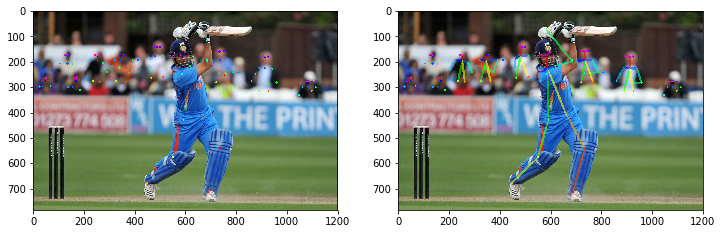

In [17]:
%%time

subsets, img_points = draw_key_point(subsets, peaks, img_ori)
img_canvas = link_key_point(img_points, candidates, subsets)

# cv2.imwrite('result.png', img_canvas)   

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_points[...,::-1])

plt.subplot(1, 2, 2)
plt.imshow(img_canvas[...,::-1])